# Building a WaveNet

## Starter Code

### Imports

In [1]:
import numpy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### Read words

In [5]:
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


### Build vocabulary of characters and mapping to/from integers

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Shuffle words

In [7]:
import random
random.seed(42)
random.shuffle(words)

### Build the dataset

In [8]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


### Neural Network

In [45]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [46]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [47]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [19]:
torch.manual_seed(42);

In [20]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameter init
with torch.no_grad():
    layers[-1].weight * 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [92]:
C.shape, Xb.shape, C[Xb].shape

(torch.Size([27, 10]), torch.Size([32, 8]), torch.Size([32, 8, 10]))

### Training

In [21]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.4915
  10000/ 200000:  2.2179
  20000/ 200000:  2.3681
  30000/ 200000:  2.1342
  40000/ 200000:  2.4067
  50000/ 200000:  2.2406
  60000/ 200000:  1.9608
  70000/ 200000:  1.9236
  80000/ 200000:  2.6588
  90000/ 200000:  2.0502
 100000/ 200000:  2.2596
 110000/ 200000:  1.6270
 120000/ 200000:  2.1705
 130000/ 200000:  2.2806
 140000/ 200000:  2.1980
 150000/ 200000:  1.8434
 160000/ 200000:  1.8251
 170000/ 200000:  2.3077
 180000/ 200000:  2.0817
 190000/ 200000:  2.1585


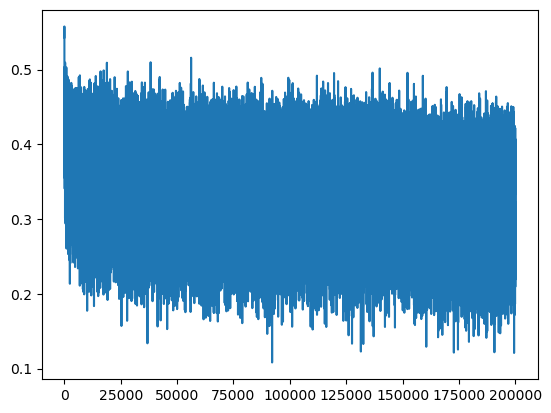

In [22]:
plt.plot(lossi)

### Eval Mode

In [23]:
# put layers into eval mode (needed for batchnorm especially)

for layer in layers:
    layer.training = False

In [25]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {  
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.058220624923706
val 2.1056690216064453


### Sample from model

In [26]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0: break
        
    print(''.join(itos[i] for i in out))

ivon.
fanili.
thoommestenell.
mattevyn.
alana.
joleshaun.
siah.
prus.
carleen.
jah.
jorrena.
joriah.
jas.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.
esteffead.


## Fix the lr plot

In [28]:
lossi[:10]

[0.5430157780647278,
 0.5576249957084656,
 0.523175835609436,
 0.5327444672584534,
 0.5206513404846191,
 0.5284044742584229,
 0.5306796431541443,
 0.5056970119476318,
 0.5213009119033813,
 0.5147265195846558]

In [34]:
torch.arange(10).view(2, 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [35]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

In [36]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

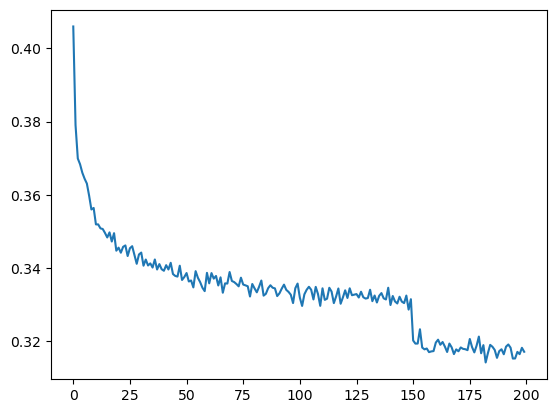

In [37]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

## Pytorchifying the code
> layers, containers, torch.nn, fun bugs

#### Layers
> Introducing new layers: embedding, flatten

In [48]:
class Embedding: 
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

In [49]:
class Flatten:
    
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [52]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameter init
with torch.no_grad():
    layers[-1].weight * 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [53]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.5082
  10000/ 200000:  2.0571
  20000/ 200000:  2.2413
  30000/ 200000:  2.4639
  40000/ 200000:  2.2263
  50000/ 200000:  2.3571
  60000/ 200000:  2.1370
  70000/ 200000:  2.7671
  80000/ 200000:  2.2382
  90000/ 200000:  2.0209
 100000/ 200000:  2.3002
 110000/ 200000:  2.4398
 120000/ 200000:  2.0523
 130000/ 200000:  2.3710
 140000/ 200000:  1.8653
 150000/ 200000:  2.2184
 160000/ 200000:  2.0450
 170000/ 200000:  2.1662
 180000/ 200000:  2.4111
 190000/ 200000:  2.2235


#### Containers

In [78]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [79]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight * 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [80]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.5305
  10000/ 200000:  2.2110
  20000/ 200000:  2.2748
  30000/ 200000:  2.1262
  40000/ 200000:  2.0688
  50000/ 200000:  2.1548
  60000/ 200000:  2.3199
  70000/ 200000:  2.1442
  80000/ 200000:  2.3574
  90000/ 200000:  2.1655
 100000/ 200000:  2.0048
 110000/ 200000:  1.8850
 120000/ 200000:  2.5728
 130000/ 200000:  2.1003
 140000/ 200000:  2.3241
 150000/ 200000:  1.9660
 160000/ 200000:  2.6264
 170000/ 200000:  1.9312
 180000/ 200000:  2.0162
 190000/ 200000:  2.5534


#### eval mode

In [81]:
# put layers into eval mode (needed for batchnorm especially)

for layer in model.layers:
    layer.training = False

In [82]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {  
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0617716312408447
val 2.107328414916992


#### Sample from model

In [83]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0: break
        
    print(''.join(itos[i] for i in out))

emrie.
ora.
hayne.
ten.
loria.
codilel.
sanda.
breiley.
holi.
odessan.
bredonyaelaven.
jarey.
laiza.
aalyn.
cia.
jadelchum.
kion.
ijahilob.
briahimmorlenia.
roah.


## Increase the context size

In [84]:
block_size = 8

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [85]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [87]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight * 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


#### training mode

In [88]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.4608
  10000/ 200000:  1.8848
  20000/ 200000:  1.7580
  30000/ 200000:  2.8692
  40000/ 200000:  2.2771
  50000/ 200000:  2.5837
  60000/ 200000:  2.0078
  70000/ 200000:  1.8744
  80000/ 200000:  1.9563
  90000/ 200000:  2.2145
 100000/ 200000:  1.9272
 110000/ 200000:  1.9304
 120000/ 200000:  1.6209
 130000/ 200000:  2.1272
 140000/ 200000:  1.5357
 150000/ 200000:  2.1351
 160000/ 200000:  1.9035
 170000/ 200000:  2.2838
 180000/ 200000:  1.7713
 190000/ 200000:  2.3871


#### eval mode

In [89]:
# put layers into eval mode (needed for batchnorm especially)

for layer in model.layers:
    layer.training = False

In [90]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {  
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9167368412017822
val 2.024416923522949


### Performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027

In [91]:
# sample from model

for _ in range(20):
    
    out = []
    context = [0] * block_size
    
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))

iappyub.
linael.
lenimane.
mickuy.
gurtrucie.
daiah.
giorgencee.
syairelle.
kazell.
gavlan.
xodalanne.
elessa.
jakari.
aleky.
sala.
bekkelon.
gragil.
kamet.
waiann.
anaiyah.


## Implementing Wavenet

In [94]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # lets look at batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 18, 21,  4, 15, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [12,  5, 24,  1, 14,  4, 18,  9],
        [ 0,  0,  0,  0,  0,  0, 16, 18]])

In [95]:
ix

tensor([123190,  40566,  83836, 119929])

In [96]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [97]:
model.layers[1].out.shape

torch.Size([4, 80])

In [98]:
model.layers[2].out.shape

torch.Size([4, 200])

In [99]:
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

In [100]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [ ]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10d vectors are concatenated